In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from IPython import display
from torchvision import datasets, models, transforms
from tqdm import trange

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# https://github.com/activatedgeek/LeNet-5/blob/master/lenet.py
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self, p=0.5):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5), padding=2)),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5), padding=2)),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(1080, 84)),
            ('relu6', nn.ReLU()),
            ('dropout6', nn.Dropout(p)),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [3]:
def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

train_size = len(train_loader.dataset)
test_size = len(test_loader.dataset)

print(train_size, test_size)

for x, y in train_loader:
    print(x.size(), y.size())
    break

60000 10000
torch.Size([32, 1, 28, 28]) torch.Size([32])


In [4]:
def train(model, optimizer, scheduler, train_loader, val_loader, device, MODEL_PATH, PLOT_PATH, epochs_n=20, batch_size=32):
    model.to(device)
    
    train_loss_curve = [np.nan] * epochs_n
    val_loss_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    train_size = len(train_loader.dataset)
    val_size = len(val_loader.dataset)

    n_batches_train = (train_size - 1) // batch_size + 1
    n_batches_val = (val_size - 1) // batch_size + 1

    for epoch in trange(epochs_n):
        model.train()

        train_loss_curve[epoch] = 0
        train_accuracy_curve[epoch] = 0
        
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            
            labels_pred = prediction.argmax(dim=-1, keepdim=True).view(-1)
            train_accuracy_curve[epoch] += labels_pred.eq(y).sum().item() / len(y)
            
            loss = F.nll_loss(prediction, y)
            train_loss_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        
        train_accuracy_curve[epoch] /= n_batches_train

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 5))

        train_loss_curve[epoch] /= n_batches_train
        axes[0].plot(train_loss_curve, label='train')

        model.eval()

        val_loss_curve[epoch] = 0
        val_accuracy_curve[epoch] = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                prediction = model(x)

                labels_pred = prediction.argmax(dim=-1, keepdim=True).view(-1)
                val_accuracy_curve[epoch] += labels_pred.eq(y).sum().item() / len(y)

                loss = F.nll_loss(prediction, y)
                val_loss_curve[epoch] += loss.item()
        
        scheduler.step()
        
        val_accuracy_curve[epoch] /= n_batches_val
        val_loss_curve[epoch] /= n_batches_val
        axes[0].plot(val_loss_curve, label='val')
        axes[0].set_title('Loss: train {:.4f}, val {:.4f}'.format(train_loss_curve[epoch], val_loss_curve[epoch]))
        axes[0].legend()
        axes[0].set_xlabel('epochs')
        axes[0].set_ylabel('loss')
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            torch.save(model.state_dict(), MODEL_PATH)
        
        axes[1].set_title('Accuracy: train {:.4f}, val {:.4f}'.format(train_accuracy_curve[epoch], val_accuracy))
        axes[1].plot(train_accuracy_curve, label='train')
        axes[1].plot(val_accuracy_curve, label='val')
        axes[1].legend()
        axes[1].set_xlabel('epochs')
        axes[1].set_ylabel('accuracy')

        plt.tight_layout()
        if epoch == epochs_n - 1:
            plt.savefig(PLOT_PATH)
        plt.show()
    
    return np.array(train_loss_curve), np.array(val_loss_curve), np.array(train_accuracy_curve),\
            np.array(val_accuracy_curve), max_val_accuracy, max_val_accuracy_epoch

### LeNet: p=0.5 (as in the paper)

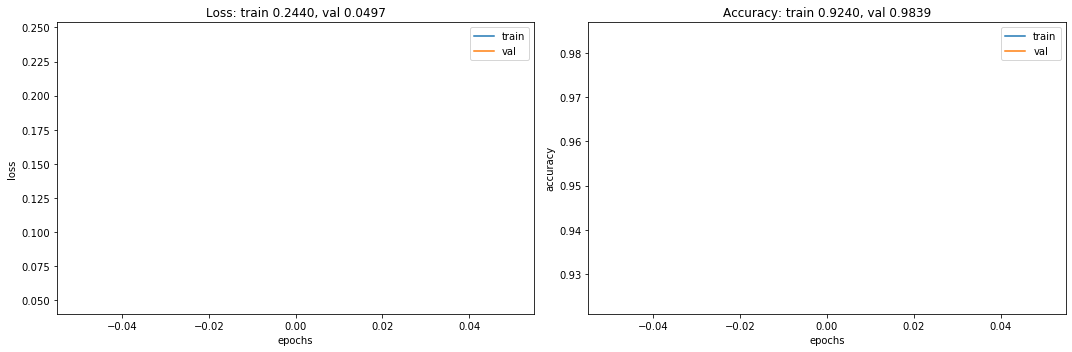

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.95s/it]


Max accuracy: 0.983926 at epoch 0


In [5]:
set_random_seeds(13, device)

lr = 0.01
epochs_n = 500
momentum = 0.9
weight_decay = 1e-6

model_name = 'lenet_dropout_0-5'
model_path = 'models/{}.pt'.format(model_name)
plot_path = 'logs/{}_logs.png'.format(model_name)

model = LeNet5(p=0.5).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

def lr_policy(epoch):
    return (1 + 0.0001 * epoch)**(-0.75)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_policy)

train_loss_curve, test_loss_curve, train_accuracy_curve, test_accuracy_curve, max_test_accuracy, max_test_accuracy_epoch = \
       train(model, optimizer, scheduler, train_loader, test_loader, device, model_path, plot_path, epochs_n, batch_size)

LOG_DIR = 'logs'
np.save(os.path.join(LOG_DIR, '{}_train_loss.npy'.format(model_name)), train_loss_curve)
np.save(os.path.join(LOG_DIR, '{}_test_loss.npy'.format(model_name)), test_loss_curve)
np.save(os.path.join(LOG_DIR, '{}_train_accuracy.npy'.format(model_name)), train_accuracy_curve)
np.save(os.path.join(LOG_DIR, '{}_test_accuracy.npy'.format(model_name)), test_accuracy_curve)
print('Max accuracy: {:.6f} at epoch {}'.format(max_test_accuracy, max_test_accuracy_epoch))

### LeNet: p=0.25

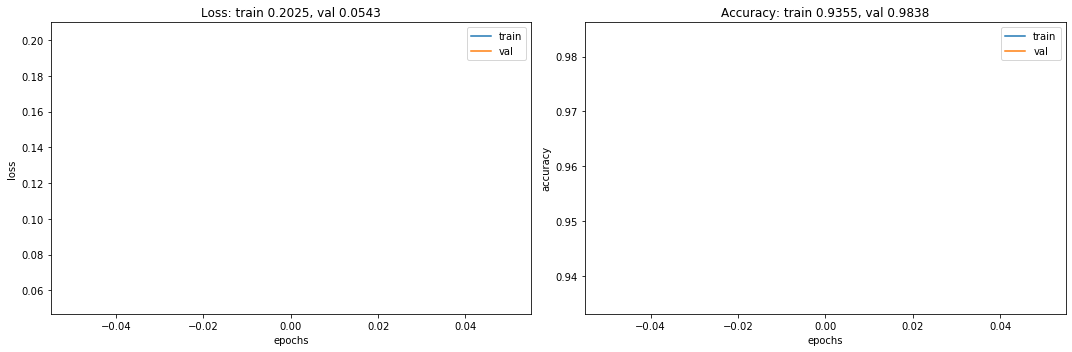

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.45s/it]


Max accuracy: 0.983826 at epoch 0


In [6]:
set_random_seeds(13, device)

lr = 0.01
epochs_n = 500
momentum = 0.9
weight_decay = 1e-6

model_name = 'lenet_dropout_0-25'
model_path = 'models/{}.pt'.format(model_name)
plot_path = 'logs/{}_logs.png'.format(model_name)

model = LeNet5(p=0.25).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

def lr_policy(epoch):
    return (1 + 0.0001 * epoch)**(-0.75)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_policy)

train_loss_curve, test_loss_curve, train_accuracy_curve, test_accuracy_curve, max_test_accuracy, max_test_accuracy_epoch = \
       train(model, optimizer, scheduler, train_loader, test_loader, device, model_path, plot_path, epochs_n, batch_size)

LOG_DIR = 'logs'
np.save(os.path.join(LOG_DIR, '{}_train_loss.npy'.format(model_name)), train_loss_curve)
np.save(os.path.join(LOG_DIR, '{}_test_loss.npy'.format(model_name)), test_loss_curve)
np.save(os.path.join(LOG_DIR, '{}_train_accuracy.npy'.format(model_name)), train_accuracy_curve)
np.save(os.path.join(LOG_DIR, '{}_test_accuracy.npy'.format(model_name)), test_accuracy_curve)
print('Max accuracy: {:.6f} at epoch {}'.format(max_test_accuracy, max_test_accuracy_epoch))

### LeNet: p=0.75

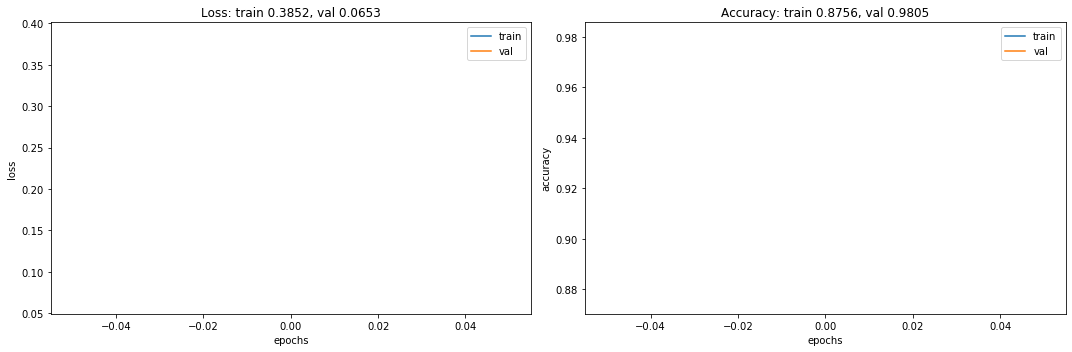

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.56s/it]


Max accuracy: 0.980531 at epoch 0


In [7]:
set_random_seeds(13, device)

lr = 0.01
epochs_n = 500
momentum = 0.9
weight_decay = 1e-6

model_name = 'lenet_dropout_0-75'
model_path = 'models/{}.pt'.format(model_name)
plot_path = 'logs/{}_logs.png'.format(model_name)

model = LeNet5(p=0.75).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

def lr_policy(epoch):
    return (1 + 0.0001 * epoch)**(-0.75)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_policy)

train_loss_curve, test_loss_curve, train_accuracy_curve, test_accuracy_curve, max_test_accuracy, max_test_accuracy_epoch = \
       train(model, optimizer, scheduler, train_loader, test_loader, device, model_path, plot_path, epochs_n, batch_size)

LOG_DIR = 'logs'
np.save(os.path.join(LOG_DIR, '{}_train_loss.npy'.format(model_name)), train_loss_curve)
np.save(os.path.join(LOG_DIR, '{}_test_loss.npy'.format(model_name)), test_loss_curve)
np.save(os.path.join(LOG_DIR, '{}_train_accuracy.npy'.format(model_name)), train_accuracy_curve)
np.save(os.path.join(LOG_DIR, '{}_test_accuracy.npy'.format(model_name)), test_accuracy_curve)
print('Max accuracy: {:.6f} at epoch {}'.format(max_test_accuracy, max_test_accuracy_epoch))